# Systrace Parser

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2020-09-25 05:26:31,524 INFO    : root         : Using LISA logging configuration:
2020-09-25 05:26:31,525 INFO    : root         :   /home/ubuntu/Android/lisa_old/logging.conf


In [2]:
%pylab inline

import os
from time import sleep

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload

from devlib.utils.android import adb_command

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy
import glob

import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

import ipywidgets as widgets
from IPython.display import display

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Javascript, display

from android import System

import subprocess

from systrace_parser import systrace_parser

2020-09-25 05:26:31,784 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt
2020-09-25 05:26:31,798 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt


Populating the interactive namespace from numpy and matplotlib


## Test environment setup

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [3]:
import os
os.environ['ANDROID_HOME'] = '/home/ubuntu/Android/AndroidSDK/'

In [4]:
conf = {
    
    # Target platform and board
    "platform"    : 'android',
    "board"       : 'pixel',

    # Device ID
    #"device"      : "HT6670300102",
    
    # Android home
    "ANDROID_HOME" : "/home/ubuntu/Android/AndroidSDK",
    
    # Lisa home
    "LISA_HOME" : "/home/ubuntu/Android/lisa_old",

    # Systrace home
    "SYSTRACE_HOME" : "/ipynb/performance/testingdata",
    
    "MAX_CORE_NUM" : 8
}

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Filters

In [6]:
trace_mark_filters = {
    'launching' : {
        'SMARK' : {'context' : 'launching:', 'type' : 'S'}, 
        'EMARK' : {'context' : 'launching:', 'type' : 'F'},
    },
    'ActivityThreadMain' : {
        'SMARK' : {'context' : 'ActivityThreadMain', 'type' : 'B'}, 
        'EMARK' : {'context' : 'ActivityThreadMain', 'type' : 'E'},
    },
    'bindApplication' : {
        'SMARK' : {'context' : 'bindApplication', 'type' : 'B'}, 
        'EMARK' : {'context' : 'bindApplication', 'type' : 'E'},
    },
    'activityStart' : {
        'SMARK' : {'context' : 'activityStart', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityStart', 'type' : 'E'},
    },
    'activityResume' : {
        'SMARK' : {'context' : 'activityResume', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityResume', 'type' : 'E'},
    },
    'Choreographer' : {
        'SMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'B'}, 
        'EMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'E'},
        'SEPERATE' : [0, 1],
    },
    'setSurface' : {
        'SMARK' : {'context' : 'setSurface', 'type' : 'B'}, 
        'EMARK' : {'context' : 'setSurface', 'type' : 'E'},
    },
}

In [7]:
def MismatchedStringWithoutNumber(comp1, comp2):
    comp1 = unicode(comp1)
    comp2 = unicode(comp2)
    count = 0
    for index in range(min(len(comp1), len(comp2))):
        if comp1[index] != comp2[index] and not comp1[index].isnumeric() and not comp1[index].isnumeric():
            count += 1
            
    return count
#print(MismatchedStringWithoutNumber('A207FSH9_POS_190822_190822_104817_calllog?', 'A207FSH9_POS_190822_180922_104475_calllog1'))

## Select systraces

In [8]:

count = 0
dirname = ''
dirnames = ''
chboxes = list()
chboxes_descriptions = list()

for (path, dir, files) in os.walk(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/'):
    if len(dir) > 0:
        dirnames = dir
    file_groups = list()
    for filename in files:
        if filename.split('.')[-1] == 'html':
            filename = filename[:-5]
            #print(filename)
            new_one = True
            for file_group in file_groups:
                #length_of_file = len(filename)
                #if length_of_file == len(file_group) and filename[:length_of_file/2] == file_group[:length_of_file/2]:
                if not MismatchedStringWithoutNumber(filename, file_group):
                    #print('before  {}'.format(file_groups))
                    #if not file_group.contains('[?]'):
                    #    file_groups.remove(file_group)
                        #file_groups.append('{}?{}'.format(file_group[:-6],file_group[-5:]))
                    #    file_groups.append('{}[?]'.format(file_group[:-3]))
                        #print('after  {}'.format(file_groups))
                    new_one = False
                    break
            if new_one:
                file_groups.append(filename)

    for file_group in file_groups:
        chboxes_descriptions.append('{}{}'.format(dirname, file_group))
    if len(dirnames) > count:
        dirname = dirnames[count] + '/'
    else:
        dirname = ''
    count += 1
    
chboxes_descriptions.sort()
#display(chboxes_descriptions)
for chboxes_description in chboxes_descriptions:
        chboxes.append(widgets.Checkbox(
                value=False,
                description=chboxes_description.decode("utf-8"),
                disabled=False,
                layout=widgets.Layout(width="200%"),
                style={'description_width': 'initial'}
        ))

toggle = widgets.ToggleButton(
    description='START'
)

#chboxes[4].value = True
#chboxes[16].value = True

display(widgets.VBox(chboxes))

VkJveChjaGlsZHJlbj0oQ2hlY2tib3godmFsdWU9RmFsc2UsIGRlc2NyaXB0aW9uPXUnMTRJR1pVUC9hcXVlZHVjdHMnLCBsYXlvdXQ9TGF5b3V0KHdpZHRoPXUnMjAwJScpLCBzdHlsZT1EZXPigKY=


## Run cells

Please select over systrace files and press the run button to execute below cells.

In [11]:
def run_all(button):
    #get_ipython().run_cell()
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Run all below")
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

Button(description=u'Run all below', style=ButtonStyle())

## Get file list

In [12]:
filelist = list()
title = list()

for chbox in chboxes:
    if chbox.value:
        #print(chbox.description)
        file_path = chbox.description.split('/')
        new_file_path = ''
        if len(file_path) > 1:
            for idx in range(len(file_path) - 1):
                new_file_path += file_path[idx] + '/'
        #length_of_file = len(file_path[-1])
        #new_file_path += file_path[-1][:-3] + '*.html'
        new_file_path += '*.html'
        #print(new_file_path)
        
        gathering_filelist = list()
        for dir_file in glob.glob(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/' + new_file_path):
            if not MismatchedStringWithoutNumber(file_path[-1], dir_file.split('/')[-1]):
                #print(dir_file)
                gathering_filelist.append(dir_file)
        filelist.append(gathering_filelist)
        #filelist[-1].sort()
        title += [file_path[-2] + "_" + file_path[-1]]

if len(filelist) == 0:
    raise  ValueError('Please select some groups of systrace in the over cell.')

Please select some systraces to analysis.

## Read Files

In [13]:
group1 = systrace_parser(trace_mark_filters, filelist[0], title[0])
group2 = systrace_parser(trace_mark_filters, filelist[1], title[1])

In [14]:
group1.run()
group2.run()

Parsing atrace_APUSBrowser_iteration_1.html - 104142 lines are Ok
Parsing atrace_APUSBrowser_iteration_10.html - 102726 lines are Ok
Parsing atrace_APUSBrowser_iteration_3.html - 101357 lines are Ok
Parsing atrace_APUSBrowser_iteration_2.html - 111259 lines are Ok
Parsing atrace_APUSBrowser_iteration_7.html - 104938 lines are Ok
Parsing atrace_APUSBrowser_iteration_9.html - 103042 lines are Ok
Parsing atrace_APUSBrowser_iteration_5.html - 102788 lines are Ok
Parsing atrace_APUSBrowser_iteration_8.html - 102005 lines are Ok
Parsing atrace_APUSBrowser_iteration_6.html - 103953 lines are Ok
Parsing atrace_APUSBrowser_iteration_4.html - 103391 lines are Ok
Parsing atrace_APUSBrowser_iteration_1.html - 110789 lines are Ok
Parsing atrace_APUSBrowser_iteration_10.html - 106932 lines are Ok
Parsing atrace_APUSBrowser_iteration_3.html - 96152 lines are Ok
Parsing atrace_APUSBrowser_iteration_2.html - 102008 lines are Ok
Parsing atrace_APUSBrowser_iteration_7.html - 97076 lines are Ok
Parsing at

## Analysis

### The timing of marking data

The operation times of each trace_mark_filters.

In [15]:
list_of_df = group1.get_marking_time()
print(group1.title)
for df in list_of_df:
    display(df * 1000)

6JHF19_APUS_atrace_APUSBrowser_iteration_1


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1409.0,NaN,7.147,1.370,NaN,NaN,NaN,NaN,NaN
1410.0,NaN,2.336,1.442,NaN,NaN,NaN,NaN,NaN
10599.0,NaN,6.766,NaN,NaN,NaN,NaN,NaN,NaN
2187.0,NaN,0.123,0.202,NaN,NaN,NaN,NaN,NaN
3213.0,2.442,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1230.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,202.383
12303.0,NaN,58.253,2.082,NaN,19.05,NaN,53.756,NaN
4084.0,0.011,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14038.0,8.502,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1409.0,NaN,7.600,14.779,NaN,NaN,NaN,NaN,NaN
1410.0,NaN,2.836,1.035,NaN,NaN,NaN,NaN,NaN
10599.0,NaN,5.280,NaN,NaN,NaN,NaN,NaN,NaN
2187.0,NaN,0.182,0.196,NaN,NaN,NaN,NaN,NaN
3213.0,2.409,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1230.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,193.328
12303.0,NaN,46.742,2.027,NaN,26.476,NaN,48.369,NaN
4084.0,0.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14038.0,8.835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1409.0,NaN,7.593,13.845,NaN,NaN,NaN,NaN,NaN
1410.0,NaN,2.172,1.368,NaN,NaN,NaN,NaN,NaN
10599.0,NaN,4.740,NaN,NaN,NaN,NaN,NaN,NaN
2187.0,NaN,0.374,0.155,NaN,NaN,NaN,NaN,NaN
3213.0,2.595,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1230.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,175.139
12303.0,NaN,44.470,1.885,NaN,20.161,NaN,45.969,NaN
4084.0,0.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14038.0,7.988,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1409.0,NaN,1.129,12.142,NaN,NaN,NaN,NaN,NaN
1410.0,NaN,4.882,1.425,NaN,NaN,NaN,NaN,NaN
10599.0,NaN,8.686,NaN,NaN,NaN,NaN,NaN,NaN
2187.0,NaN,0.168,0.161,NaN,NaN,NaN,NaN,NaN
3213.0,3.034,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1230.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.792
12303.0,NaN,46.213,2.233,NaN,18.352,NaN,48.141,NaN
4084.0,0.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14038.0,8.442,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1409.0,NaN,7.136,14.060,NaN,NaN,NaN,NaN,NaN
1410.0,NaN,5.742,2.183,NaN,NaN,NaN,NaN,NaN
10599.0,NaN,5.148,NaN,NaN,NaN,NaN,NaN,NaN
2187.0,NaN,0.191,0.189,NaN,NaN,NaN,NaN,NaN
3213.0,2.284,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1230.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186.365
12303.0,NaN,46.263,2.694,NaN,26.423,NaN,46.718,NaN
4084.0,0.005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14038.0,8.837,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1409.0,NaN,1.271,14.928,NaN,NaN,NaN,0.401,NaN
1410.0,NaN,2.438,1.358,NaN,NaN,NaN,NaN,NaN
7269.0,NaN,NaN,NaN,NaN,NaN,NaN,1.148,NaN
10599.0,NaN,5.643,NaN,NaN,NaN,NaN,NaN,NaN
2187.0,NaN,0.204,0.180,NaN,NaN,NaN,NaN,NaN
3213.0,2.656,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1230.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,183.516
12303.0,NaN,47.363,1.666,NaN,22.961,NaN,45.071,NaN
4084.0,0.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1409.0,NaN,7.117,1.123,NaN,NaN,NaN,NaN,NaN
1410.0,NaN,5.952,1.518,NaN,NaN,NaN,NaN,NaN
10599.0,NaN,8.460,NaN,NaN,NaN,NaN,NaN,NaN
2187.0,NaN,0.173,0.178,NaN,NaN,NaN,NaN,NaN
3213.0,2.446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1230.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,189.569
12303.0,NaN,44.894,1.782,NaN,19.504,NaN,46.184,NaN
4084.0,0.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14038.0,8.653,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1409.0,NaN,7.257,15.768,NaN,NaN,NaN,NaN,NaN
1410.0,NaN,2.897,1.503,NaN,NaN,NaN,NaN,NaN
10599.0,NaN,6.134,NaN,NaN,NaN,NaN,NaN,NaN
2187.0,NaN,0.123,0.201,NaN,NaN,NaN,NaN,NaN
3213.0,2.563,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1230.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179.011
12303.0,NaN,48.749,1.604,NaN,20.54,NaN,46.335,NaN
4084.0,0.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14038.0,8.948,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1409.0,NaN,7.396,13.762,NaN,NaN,NaN,NaN,NaN
1410.0,NaN,2.538,1.354,NaN,NaN,NaN,NaN,NaN
10599.0,NaN,6.880,NaN,NaN,NaN,NaN,NaN,NaN
2187.0,NaN,0.130,0.188,NaN,NaN,NaN,NaN,NaN
3213.0,2.483,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1230.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,194.522
12303.0,NaN,47.457,1.917,NaN,26.133,NaN,46.987,NaN
4084.0,0.005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14038.0,7.927,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1409.0,NaN,9.066,1.111,NaN,NaN,NaN,NaN,NaN
1410.0,NaN,2.503,1.426,NaN,NaN,NaN,NaN,NaN
10599.0,NaN,4.056,NaN,NaN,NaN,NaN,NaN,NaN
2187.0,NaN,0.183,0.174,NaN,NaN,NaN,NaN,NaN
3213.0,2.552,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1230.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187.5
12303.0,NaN,47.788,1.986,NaN,23.173,NaN,46.659,NaN
4084.0,0.007,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14038.0,8.864,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
list_of_df = group2.get_marking_time()
print(group2.title)
for df in list_of_df:
    display(df * 1000)

6JHF5_APUS_atrace_APUSBrowser_iteration_1


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
7526.0,3.096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8167.0,NaN,6.987,NaN,NaN,NaN,NaN,NaN,NaN
8270.0,0.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14253.0,NaN,47.454,2.707,NaN,9.256,NaN,37.924,NaN
5806.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155.453
6416.0,NaN,0.176,0.158,NaN,NaN,NaN,NaN,NaN
5906.0,NaN,1.198,9.977,NaN,NaN,NaN,NaN,NaN
5907.0,NaN,2.827,0.692,NaN,NaN,NaN,NaN,NaN
17460.0,5.417,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
7526.0,2.928,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8167.0,NaN,5.839,NaN,NaN,NaN,NaN,NaN,NaN
8270.0,0.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14253.0,NaN,41.521,1.612,NaN,20.633,NaN,37.345,NaN
5806.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155.025
6416.0,NaN,0.387,0.319,NaN,NaN,NaN,NaN,NaN
5906.0,NaN,5.665,10.284,NaN,NaN,NaN,NaN,NaN
5907.0,NaN,4.006,0.684,NaN,NaN,NaN,NaN,NaN
17460.0,1.252,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
7526.0,2.835,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8167.0,NaN,5.979,NaN,NaN,NaN,NaN,NaN,NaN
8270.0,0.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14253.0,NaN,37.755,1.701,NaN,17.971,NaN,34.492,NaN
5806.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,153.12
6416.0,NaN,0.270,0.361,NaN,NaN,NaN,NaN,NaN
5906.0,NaN,1.230,7.498,NaN,NaN,NaN,NaN,NaN
5907.0,NaN,1.913,0.441,NaN,NaN,NaN,NaN,NaN
17460.0,1.195,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
19792.0,NaN,NaN,NaN,NaN,NaN,NaN,0.154,NaN
7526.0,3.714,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8167.0,NaN,6.497,NaN,NaN,NaN,NaN,NaN,NaN
8270.0,0.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14253.0,NaN,37.239,1.407,NaN,15.888,NaN,36.393,NaN
5806.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,146.289
6416.0,NaN,0.425,0.332,NaN,NaN,NaN,NaN,NaN
5906.0,NaN,6.259,0.829,NaN,NaN,NaN,0.630,NaN
5907.0,NaN,1.848,0.488,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
7526.0,3.041,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8167.0,NaN,14.354,NaN,NaN,NaN,NaN,NaN,NaN
8270.0,0.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14253.0,NaN,40.705,3.199,NaN,19.48,NaN,33.42,NaN
5806.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.388
6416.0,NaN,0.360,0.375,NaN,NaN,NaN,NaN,NaN
5906.0,NaN,5.937,2.720,NaN,NaN,NaN,NaN,NaN
5907.0,NaN,1.089,0.965,NaN,NaN,NaN,NaN,NaN
17460.0,1.173,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
7526.0,4.293,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8167.0,NaN,8.636,NaN,NaN,NaN,NaN,NaN,NaN
8270.0,0.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14253.0,NaN,38.345,1.263,NaN,19.061,NaN,36.443,NaN
5806.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,151.722
6416.0,NaN,0.262,0.349,NaN,NaN,NaN,NaN,NaN
5906.0,NaN,11.217,0.938,NaN,NaN,NaN,NaN,NaN
5907.0,NaN,4.198,0.630,NaN,NaN,NaN,NaN,NaN
17460.0,1.279,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
7526.0,3.156,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8167.0,NaN,8.550,NaN,NaN,NaN,NaN,NaN,NaN
8270.0,0.005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14253.0,NaN,35.373,1.276,NaN,13.594,NaN,37.057,NaN
5806.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155.944
6416.0,NaN,0.364,0.566,NaN,NaN,NaN,NaN,NaN
5906.0,NaN,1.001,7.683,NaN,NaN,NaN,NaN,NaN
5907.0,NaN,1.155,1.806,NaN,NaN,NaN,NaN,NaN
17460.0,1.214,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
7526.0,3.134,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8167.0,NaN,8.422,NaN,NaN,NaN,NaN,NaN,NaN
8270.0,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14253.0,NaN,35.751,1.242,NaN,24.777,NaN,34.816,NaN
5806.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.484
6416.0,NaN,0.439,0.340,NaN,NaN,NaN,NaN,NaN
5906.0,NaN,12.195,1.475,NaN,NaN,NaN,NaN,NaN
5907.0,NaN,1.738,0.495,NaN,NaN,NaN,NaN,NaN
17460.0,1.317,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
7526.0,3.136,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8167.0,NaN,6.221,NaN,NaN,NaN,NaN,NaN,NaN
8270.0,0.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14253.0,NaN,42.390,2.308,NaN,17.089,NaN,35.608,NaN
5806.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155.628
6416.0,NaN,0.324,0.347,NaN,NaN,NaN,NaN,NaN
5906.0,NaN,1.544,8.061,NaN,NaN,NaN,NaN,NaN
5907.0,NaN,4.422,0.837,NaN,NaN,NaN,NaN,NaN
17460.0,1.243,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
7526.0,2.919,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8167.0,NaN,5.486,NaN,NaN,NaN,NaN,NaN,NaN
8270.0,0.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14253.0,NaN,35.371,1.219,NaN,15.337,NaN,33.012,NaN
5806.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,148.663
6416.0,NaN,0.298,0.354,NaN,NaN,NaN,NaN,NaN
5906.0,NaN,1.091,16.763,NaN,NaN,NaN,NaN,NaN
5907.0,NaN,1.712,0.845,NaN,NaN,NaN,NaN,NaN
17460.0,1.023,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Launching Time(AVERAGE)

This section is showing the app launching time.

In [17]:
list_of_df = group1.get_marking_time()
sum_df1 = None

for df in list_of_df:
    get_launching = df[df['launching'] > 0]

    if len(get_launching.index) :
        try :
            sum_df1 = pd.concat([sum_df1, get_launching])
        except :
            sum_df1 = get_launching

try :
    sum_df1 = sum_df1.replace(0, NaN).dropna(axis=1) * 1000
    sum_df1.loc['mean'] = sum_df1.mean()
except:
    print("No launching time")
    
list_of_df = group2.get_marking_time()
sum_df2 = None

for df in list_of_df:
    get_launching = df[df['launching'] > 0]
    
    if len(get_launching.index) :
        try :
            sum_df2 = pd.concat([sum_df2, get_launching])
        except :
            sum_df2 = get_launching

try :
    sum_df2 = sum_df2.replace(0, NaN).dropna(axis=1) * 1000
    sum_df2.loc['mean'] = sum_df2.mean()
except:
    print("No launching time")

No launching time
No launching time


In [18]:
display(pd.concat([sum_df1, sum_df2], keys=[group1.title, group2.title], sort=False))

launching
                                           pid              
6JHF19_APUS_atrace_APUSBrowser_iteration_1 1230.0    202.383
                                           1230.0    193.328
                                           1230.0    175.139
                                           1230.0    180.792
                                           1230.0    186.365
                                           1230.0    183.516
                                           1230.0    189.569
                                           1230.0    179.011
                                           1230.0    194.522
                                           1230.0    187.500
6JHF5_APUS_atrace_APUSBrowser_iteration_1  5806.0    155.453
                                           5806.0    155.025
                                           5806.0    153.120
                                           5806.0    146.289
                                           5806.0    154.388
                                           5806.0    151.722
                                           5806.0    155.944
                                           5806.0    149.484
                                           5806.0    155.628
                                           5806.0    148.663

### Process Time(AVERAGE)

Process time is from start to end timing within systrace tag of binadApplication / activityStart / ActivityThreadMain / ActivityResume.
 - time : total sum of time of running / runnable / sleeping / uninterruptible sleep.
 - running / runnable / sleeping / uninterruptible sleep : Process stat of cores.
 - setSurface : Just test and check the length of setSurface's tags.
 - launching : Sum of each tags, bindApplication, activityStart, ActivityThreadMain, activityResume, and Choreographer.

In [19]:
df1 = group1.get(systrace_parser.process_state()) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(systrace_parser.process_state()) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

In [20]:
display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

setSurface  \
6JHF19_APUS_atrace_APUSBrowser_iteration_1 time                                0   
                                           RUNNING                             0   
                                           RUNNABLE                            0   
                                           SLEEPING                            0   
                                           UNINTERUPTIBLE_SLEEP                0   
                                           UNINTERUPTIBLE_SLEEP(I/O)           0   
6JHF5_APUS_atrace_APUSBrowser_iteration_1  time                                0   
                                           RUNNING                             0   
                                           RUNNABLE                            0   
                                           SLEEPING                            0   
                                           UNINTERUPTIBLE_SLEEP                0   
                                           UNINTERUPTIBLE_SLEEP(I/O)           0   
DIFF                                       time                                0   
                                           RUNNING                             0   
                                           RUNNABLE                            0   
                                           SLEEPING                            0   
                                           UNINTERUPTIBLE_SLEEP                0   
                                           UNINTERUPTIBLE_SLEEP(I/O)           0   

                                                                      Choreographer #0  \
6JHF19_APUS_atrace_APUSBrowser_iteration_1 time                                 47.819   
                                           RUNNING                              35.165   
                                           RUNNABLE                              0.853   
                                           SLEEPING                             11.758   
                                           UNINTERUPTIBLE_SLEEP                  0.044   
                                           UNINTERUPTIBLE_SLEEP(I/O)             0.000   
6JHF5_APUS_atrace_APUSBrowser_iteration_1  time                                 39.190   
                                           RUNNING                              28.151   
                                           RUNNABLE                              0.329   
                                           SLEEPING                             10.214   
                                           UNINTERUPTIBLE_SLEEP                  0.497   
                                           UNINTERUPTIBLE_SLEEP(I/O)             0.000   
DIFF                                       time                                  8.629   
                                           RUNNING                               7.014   
                                           RUNNABLE                              0.524   
                                           SLEEPING                              1.544   
                                           UNINTERUPTIBLE_SLEEP                 -0.453   
                                           UNINTERUPTIBLE_SLEEP(I/O)             0.000   

                                                                      Choreographer #1  \
6JHF19_APUS_atrace_APUSBrowser_iteration_1 time                                  1.988   
                                           RUNNING                               1.512   
                                           RUNNABLE                              0.085   
                                           SLEEPING                              0.391   
                                           UNINTERUPTIBLE_SLEEP                  0.000   
                                           UNINTERUPTIBLE_SLEEP(I/O)             0.000   
6JHF5_APUS_atrace_APUSBrowser_iteration_1  time                                  1.793   
                                          

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
6JHF19_APUS_atrace_APUSBrowser_iteration_1,time,0,47.819,1.988,0,22.277,0,47.419,0
6JHF5_APUS_atrace_APUSBrowser_iteration_1,time,0,39.190,1.793,0,17.309,0,35.651,0
DIFF,time,0,8.629,0.195,0,4.968,0,11.768,0


### Processing time of setSurface

In [21]:
def ProcessingTime(group, index):
    result = dict()
    list_of_df = group.get_marking_time()
    sum = 0
    count = 0
    for df in list_of_df:
        df = df['setSurface'].fillna(0)
        max_value = df.max() * 1000
        sum += max_value
        count += 1
        result[count] = [max_value]
    #print("SUM : {}, AVG : {}".format(sum, sum/count))
    result['avg'] = [sum/count]
    
    df = DataFrame.from_dict(result)
    df.index = [group.title]
    return df

In [22]:
df1 = ProcessingTime(group1, 'setSurface')
df2 = ProcessingTime(group2, 'setSurface')
display(pd.concat([df1, df2]))

,1,2,3,4,5,6,7,8,9,10,avg
6JHF19_APUS_atrace_APUSBrowser_iteration_1,8.502,8.835,7.988,8.442,8.837,9.176,8.653,8.948,7.927,8.864,8.6172
6JHF5_APUS_atrace_APUSBrowser_iteration_1,5.417,2.928,2.835,3.714,3.041,4.293,3.156,3.134,3.136,2.919,3.4573


### Uninterruptible Sleep

The count of uninterruptible sleep within each tags.

In [23]:
index1 = group1.unint_sleep()
index2 = group2.unint_sleep()
union_index = index1
for index in index2:
    if not index in union_index:
        union_index += [index]

union_index.sort()
        
df1 = group1.get(union_index, func='avg').sort_index()
df1 = df1.dropna(axis=1)

df2 = group2.get(union_index, func='avg').sort_index()
df2 = df2.dropna(axis=1)

In [24]:
print(group1.title)
display(df1)

6JHF19_APUS_atrace_APUSBrowser_iteration_1


,Choreographer #0,Choreographer #1,activityStart,activityResume
uninter_reason//__fdget_pos+0x44/0x60,0.1,0.0,0.0,0.0
uninter_reason//__rwsem_down_write_failed_common+0x280/0x40c\n\,0.0,0.0,0.0,0.0
uninter_reason//do_page_fault+0x248/0x3f0,0.9,0.0,0.1,0.0
uninter_reason//do_page_fault+0x2d4/0x454\n\,0.0,0.0,0.0,0.0
uninter_reason//vm_mmap_pgoff+0x78/0x110,0.2,0.0,0.0,0.0


In [25]:
print(group2.title)
display(df2)

6JHF5_APUS_atrace_APUSBrowser_iteration_1


,Choreographer #0,Choreographer #1,activityStart,activityResume
uninter_reason//__fdget_pos+0x44/0x60,0.0,0.0,0.0,0.0
uninter_reason//__rwsem_down_write_failed_common+0x280/0x40c\n\,0.7,0.0,0.2,0.0
uninter_reason//do_page_fault+0x248/0x3f0,0.0,0.0,0.0,0.0
uninter_reason//do_page_fault+0x2d4/0x454\n\,1.8,0.1,0.5,0.0
uninter_reason//vm_mmap_pgoff+0x78/0x110,0.0,0.0,0.0,0.0


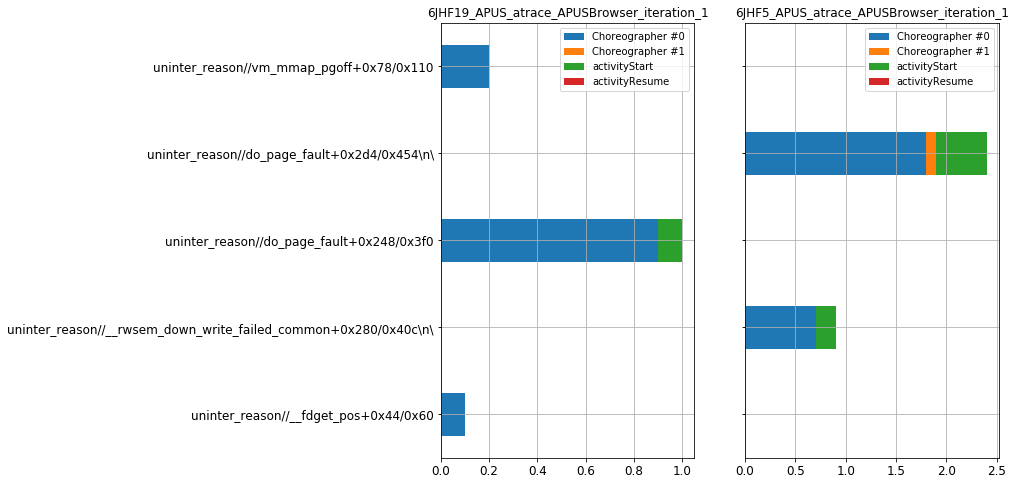

In [26]:
fig,axes = plt.subplots(nrows=1, ncols=2, sharey=True)
df1.plot(kind='barh', ax=axes[0], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group1.title)
df2.plot(kind='barh', ax=axes[1], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group2.title)

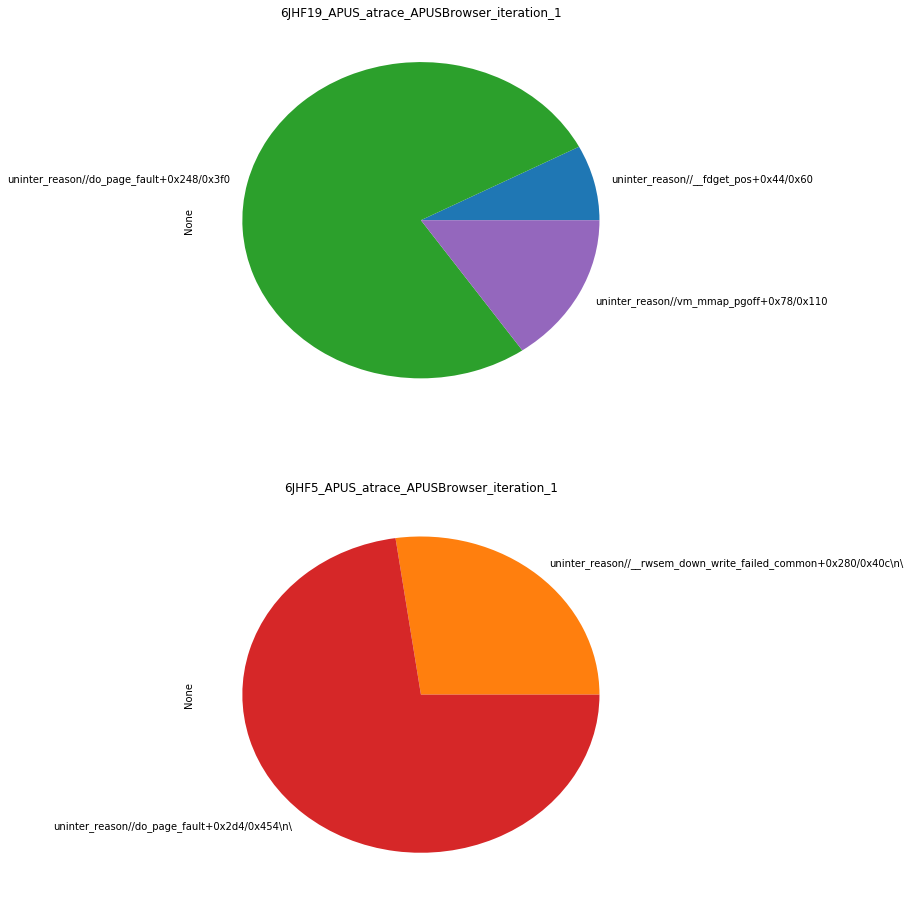

In [27]:
fig,axes = plt.subplots(nrows=2, ncols=1, sharey=True)
df1.sum(axis=1).plot(kind='pie', ax=axes[0], figsize=(8,16), title=group1.title)
df2.sum(axis=1).plot(kind='pie', ax=axes[1], figsize=(8,16), title=group2.title)

The number of count in each reason of uninterruptible sleep.

### Number of Running Cores(SUM)

The number of counting running cores when entering an app.

In [28]:
df1 = group1.get(group1.cores(), func='sum')
df1 = df1.dropna(axis=1)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(group2.cores(), func='sum')
df2 = df2.dropna(axis=1)
df2.columns.name = group2.title
#display(df2)

In [29]:
display(pd.concat([df1, df2], keys=[group1.title, group2.title], sort=False))

Choreographer #0  \
6JHF19_APUS_atrace_APUSBrowser_iteration_1 core0                 1   
                                           core1                 1   
                                           core2                 1   
                                           core3                 0   
                                           core4                45   
                                           core5                50   
                                           core6                18   
                                           core7                31   
6JHF5_APUS_atrace_APUSBrowser_iteration_1  core0                 3   
                                           core1                 1   
                                           core2                 0   
                                           core3                 1   
                                           core4                21   
                                           core5                17   
                                           core6               106   
                                           core7                30   

                                                  Choreographer #1  \
6JHF19_APUS_atrace_APUSBrowser_iteration_1 core0                 0   
                                           core1                 0   
                                           core2                 0   
                                           core3                 0   
                                           core4                 1   
                                           core5                 1   
                                           core6                 4   
                                           core7                 4   
6JHF5_APUS_atrace_APUSBrowser_iteration_1  core0                 0   
                                           core1                 0   
                                           core2                 0   
                                           core3                 1   
                                           core4                 3   
                                           core5                 0   
                                           core6                 4   
                                           core7                 5   

                                                  activityStart  \
6JHF19_APUS_atrace_APUSBrowser_iteration_1 core0             10   
                                           core1              4   
                                           core2             11   
                                           core3             37   
                                           core4             12   
                                           core5             29   
                                           core6             40   
                                           core7             32   
6JHF5_APUS_atrace_APUSBrowser_iteration_1  core0             27   
                                           core1             28   
                                           core2              5   
                                           core3             21   
                                           core4             17   
                                           core5             24   
                                           core6             16   
                                           core7             27   

                                                  activityResume  
6JHF19_APUS_atrace_APUSBrowser_iteration_1 core0               0  
                                           core1               0  
                                           core2               0  
                                           core3               0  
                                           core4             909  
                                           core5             621  
                                           core6           

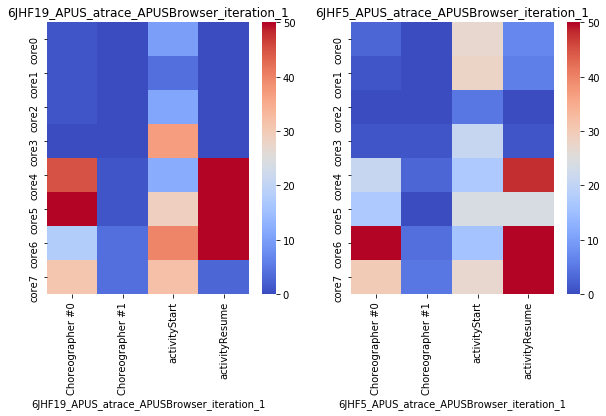

In [30]:
plt.figure(figsize=(10, 5))
#sb.palplot(sb.color_palette("hls", 8))
subplot(1,2,1, title=group1.title)
sb.heatmap(data=df1, cmap='coolwarm', center=25, vmax = 50);
subplot(1,2,2, title=group2.title)
sb.heatmap(data=df2, cmap='coolwarm', center=25, vmax = 50);

In [31]:
print(group1.title)
for parser in group1.parsers_of_testing:
    display(parser.get(group1.cores()))

6JHF19_APUS_atrace_APUSBrowser_iteration_1


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,1,0,NaN,0,NaN,0,NaN
core1,NaN,0,0,NaN,0,NaN,0,NaN
core2,NaN,0,0,NaN,4,NaN,0,NaN
core3,NaN,0,0,NaN,0,NaN,0,NaN
core4,NaN,0,0,NaN,0,NaN,31,NaN
core5,NaN,13,0,NaN,3,NaN,92,NaN
core6,NaN,1,0,NaN,12,NaN,123,NaN
core7,NaN,3,1,NaN,0,NaN,0,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,NaN,0,NaN,0,NaN
core1,NaN,0,0,NaN,0,NaN,0,NaN
core2,NaN,0,0,NaN,0,NaN,0,NaN
core3,NaN,0,0,NaN,16,NaN,0,NaN
core4,NaN,7,1,NaN,2,NaN,133,NaN
core5,NaN,1,0,NaN,2,NaN,85,NaN
core6,NaN,0,0,NaN,3,NaN,9,NaN
core7,NaN,5,0,NaN,0,NaN,0,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,NaN,3,NaN,0,NaN
core1,NaN,0,0,NaN,0,NaN,0,NaN
core2,NaN,1,0,NaN,0,NaN,0,NaN
core3,NaN,0,0,NaN,0,NaN,0,NaN
core4,NaN,1,0,NaN,0,NaN,118,NaN
core5,NaN,6,0,NaN,0,NaN,9,NaN
core6,NaN,0,1,NaN,1,NaN,99,NaN
core7,NaN,6,0,NaN,10,NaN,0,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,NaN,1,NaN,0,NaN
core1,NaN,1,0,NaN,3,NaN,0,NaN
core2,NaN,0,0,NaN,5,NaN,0,NaN
core3,NaN,0,0,NaN,0,NaN,0,NaN
core4,NaN,0,0,NaN,1,NaN,194,NaN
core5,NaN,11,0,NaN,0,NaN,25,NaN
core6,NaN,1,1,NaN,4,NaN,6,NaN
core7,NaN,3,0,NaN,0,NaN,0,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,NaN,1,NaN,0,NaN
core1,NaN,0,0,NaN,0,NaN,0,NaN
core2,NaN,0,0,NaN,0,NaN,0,NaN
core3,NaN,0,0,NaN,7,NaN,0,NaN
core4,NaN,8,0,NaN,0,NaN,86,NaN
core5,NaN,1,0,NaN,7,NaN,14,NaN
core6,NaN,1,1,NaN,3,NaN,121,NaN
core7,NaN,4,0,NaN,0,NaN,0,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,NaN,3,NaN,0,NaN
core1,NaN,0,0,NaN,0,NaN,0,NaN
core2,NaN,0,0,NaN,0,NaN,0,NaN
core3,NaN,0,0,NaN,0,NaN,0,NaN
core4,NaN,12,0,NaN,0,NaN,82,NaN
core5,NaN,0,0,NaN,12,NaN,42,NaN
core6,NaN,1,0,NaN,1,NaN,87,NaN
core7,NaN,3,1,NaN,0,NaN,0,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,NaN,1,NaN,0,NaN
core1,NaN,0,0,NaN,0,NaN,0,NaN
core2,NaN,0,0,NaN,1,NaN,0,NaN
core3,NaN,0,0,NaN,0,NaN,0,NaN
core4,NaN,9,0,NaN,0,NaN,35,NaN
core5,NaN,1,0,NaN,0,NaN,110,NaN
core6,NaN,0,1,NaN,0,NaN,86,NaN
core7,NaN,4,0,NaN,16,NaN,0,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,NaN,0,NaN,0,NaN
core1,NaN,0,0,NaN,1,NaN,0,NaN
core2,NaN,0,0,NaN,1,NaN,0,NaN
core3,NaN,0,0,NaN,1,NaN,0,NaN
core4,NaN,2,0,NaN,2,NaN,58,NaN
core5,NaN,11,0,NaN,0,NaN,140,NaN
core6,NaN,0,0,NaN,5,NaN,20,NaN
core7,NaN,2,1,NaN,6,NaN,3,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,NaN,1,NaN,0,NaN
core1,NaN,0,0,NaN,0,NaN,0,NaN
core2,NaN,0,0,NaN,0,NaN,0,NaN
core3,NaN,0,0,NaN,0,NaN,0,NaN
core4,NaN,6,0,NaN,6,NaN,91,NaN
core5,NaN,5,1,NaN,0,NaN,18,NaN
core6,NaN,0,0,NaN,7,NaN,107,NaN
core7,NaN,1,0,NaN,0,NaN,0,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,NaN,0,NaN,0,NaN
core1,NaN,0,0,NaN,0,NaN,0,NaN
core2,NaN,0,0,NaN,0,NaN,0,NaN
core3,NaN,0,0,NaN,13,NaN,0,NaN
core4,NaN,0,0,NaN,1,NaN,81,NaN
core5,NaN,1,0,NaN,5,NaN,86,NaN
core6,NaN,14,0,NaN,4,NaN,68,NaN
core7,NaN,0,1,NaN,0,NaN,0,NaN


In [32]:
print(group2.title)
for parser in group2.parsers_of_testing:
    display(parser.get(group2.cores()))

6JHF5_APUS_atrace_APUSBrowser_iteration_1


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,NaN,0,NaN,2,NaN
core1,NaN,0,0,NaN,0,NaN,0,NaN
core2,NaN,0,0,NaN,0,NaN,0,NaN
core3,NaN,0,0,NaN,3,NaN,0,NaN
core4,NaN,3,1,NaN,2,NaN,7,NaN
core5,NaN,1,0,NaN,6,NaN,1,NaN
core6,NaN,21,0,NaN,1,NaN,27,NaN
core7,NaN,3,1,NaN,6,NaN,157,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,1,0,NaN,3,NaN,0,NaN
core1,NaN,0,0,NaN,0,NaN,0,NaN
core2,NaN,0,0,NaN,1,NaN,0,NaN
core3,NaN,0,0,NaN,1,NaN,0,NaN
core4,NaN,4,0,NaN,2,NaN,9,NaN
core5,NaN,0,0,NaN,1,NaN,1,NaN
core6,NaN,9,1,NaN,1,NaN,38,NaN
core7,NaN,0,0,NaN,7,NaN,130,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,1,0,NaN,0,NaN,1,NaN
core1,NaN,0,0,NaN,2,NaN,1,NaN
core2,NaN,0,0,NaN,0,NaN,0,NaN
core3,NaN,0,0,NaN,9,NaN,0,NaN
core4,NaN,2,1,NaN,3,NaN,5,NaN
core5,NaN,1,0,NaN,3,NaN,3,NaN
core6,NaN,9,1,NaN,0,NaN,29,NaN
core7,NaN,3,0,NaN,3,NaN,143,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,NaN,0,NaN,0,NaN
core1,NaN,0,0,NaN,7,NaN,0,NaN
core2,NaN,0,0,NaN,0,NaN,0,NaN
core3,NaN,0,0,NaN,0,NaN,0,NaN
core4,NaN,1,0,NaN,0,NaN,5,NaN
core5,NaN,1,0,NaN,2,NaN,2,NaN
core6,NaN,10,0,NaN,2,NaN,24,NaN
core7,NaN,3,1,NaN,4,NaN,147,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,NaN,8,NaN,0,NaN
core1,NaN,0,0,NaN,3,NaN,0,NaN
core2,NaN,0,0,NaN,0,NaN,0,NaN
core3,NaN,0,1,NaN,0,NaN,1,NaN
core4,NaN,3,1,NaN,0,NaN,2,NaN
core5,NaN,4,0,NaN,2,NaN,4,NaN
core6,NaN,13,0,NaN,3,NaN,43,NaN
core7,NaN,3,0,NaN,0,NaN,129,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,NaN,3,NaN,0,NaN
core1,NaN,0,0,NaN,1,NaN,3,NaN
core2,NaN,0,0,NaN,0,NaN,0,NaN
core3,NaN,0,0,NaN,1,NaN,0,NaN
core4,NaN,0,0,NaN,4,NaN,2,NaN
core5,NaN,2,0,NaN,4,NaN,5,NaN
core6,NaN,11,0,NaN,0,NaN,35,NaN
core7,NaN,1,1,NaN,2,NaN,137,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,NaN,0,NaN,1,NaN
core1,NaN,0,0,NaN,2,NaN,0,NaN
core2,NaN,0,0,NaN,1,NaN,0,NaN
core3,NaN,0,0,NaN,0,NaN,0,NaN
core4,NaN,1,0,NaN,5,NaN,5,NaN
core5,NaN,1,0,NaN,3,NaN,2,NaN
core6,NaN,3,0,NaN,2,NaN,34,NaN
core7,NaN,12,1,NaN,1,NaN,137,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,NaN,5,NaN,2,NaN
core1,NaN,0,0,NaN,0,NaN,0,NaN
core2,NaN,0,0,NaN,0,NaN,0,NaN
core3,NaN,1,0,NaN,5,NaN,0,NaN
core4,NaN,2,0,NaN,1,NaN,7,NaN
core5,NaN,2,0,NaN,0,NaN,2,NaN
core6,NaN,9,0,NaN,3,NaN,35,NaN
core7,NaN,1,1,NaN,1,NaN,134,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,NaN,6,NaN,1,NaN
core1,NaN,1,0,NaN,1,NaN,1,NaN
core2,NaN,0,0,NaN,2,NaN,0,NaN
core3,NaN,0,0,NaN,1,NaN,0,NaN
core4,NaN,1,0,NaN,0,NaN,3,NaN
core5,NaN,4,0,NaN,2,NaN,2,NaN
core6,NaN,14,1,NaN,4,NaN,28,NaN
core7,NaN,2,0,NaN,1,NaN,144,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,1,0,NaN,2,NaN,0,NaN
core1,NaN,0,0,NaN,12,NaN,1,NaN
core2,NaN,0,0,NaN,1,NaN,0,NaN
core3,NaN,0,0,NaN,1,NaN,0,NaN
core4,NaN,4,0,NaN,0,NaN,3,NaN
core5,NaN,1,0,NaN,1,NaN,2,NaN
core6,NaN,7,1,NaN,0,NaN,48,NaN
core7,NaN,2,0,NaN,2,NaN,123,NaN


In [33]:
from systrace_parser import TAG_CORE_IDLE
def GetCoreStats(group):
    for parser in group.parsers_of_testing:
        rawdata = parser.get_rawdata('stat_core')
        index_key_list = list()
        df_list = list()
        
        for index_key in rawdata.keys():
            #print(index_key)
            index_key_list.append(index_key)

            core_state_dict = dict()
            for i in range(8):
                core_state_dict[i] = list()
            core_state_dict['selected'] = list()
            core_state_dict['time'] = list()

            for core_state in rawdata[index_key]:
                for i in range(8):
                    core_state_dict[i].append(core_state.get(i, TAG_CORE_IDLE))
                core_state_dict['selected'].append(core_state.get('selected', -1))
                core_state_dict['time'].append(core_state.get('time', -1))
            #display(DataFrame.from_dict(core_state_dict))
            df_list.append(DataFrame.from_dict(core_state_dict))

    return pd.concat(df_list, keys=index_key_list, sort=False).sort_values(by=['time'])
pd.set_option('display.max_rows', 500)

In [36]:
print(group1.title)
display(GetCoreStats(group1))

GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144926_gallery


0  1  2  3  4  5  6  7  selected        time
ActivityThreadMain 0   I  I  I  I  R  I  V  I         6  439.258931
                   1   R  I  I  I  I  I  V  I         6  439.259485
                   2   R  I  I  I  R  I  V  I         6  439.259749
                   3   R  I  I  I  I  I  V  I         6  439.260987
                   4   I  I  I  I  I  V  R  I         5  439.261796
                   5   I  I  I  I  I  V  R  I         5  439.262183
                   6   I  I  R  R  I  V  I  I         5  439.262852
                   7   R  I  I  I  V  I  I  I         4  439.263429
                   8   V  I  I  R  I  I  I  I         0  439.265963
                   9   R  I  R  V  R  I  R  I         3  439.266839
bindApplication    0   I  V  I  I  R  I  I  I         1  439.272355
                   1   I  V  R  R  R  I  I  I         1  439.272977
                   2   I  V  I  I  R  I  I  I         1  439.273453
                   3   I  V  I  I  I  I  I  I         1  439.275211
                   4   I  V  I  I  I  I  I  I         1  439.275556
                   5   I  I  I  V  I  I  I  R         3  439.276200
                   6   I  R  R  V  I  R  R  I         3  439.276926
                   7   I  R  V  I  I  R  R  I         2  439.277091
                   8   I  I  V  I  I  I  I  R         2  439.288144
                   9   V  R  I  I  I  I  I  R         0  439.292807
                   10  R  R  V  I  I  R  I  I         2  439.293396
                   11  R  R  I  I  V  R  I  I         4  439.295490
                   12  R  R  I  I  V  R  I  I         4  439.296177
                   13  R  R  I  I  V  R  I  I         4  439.296534
                   14  I  I  I  I  V  R  I  R         4  439.297526
                   15  I  I  I  I  V  R  I  R         4  439.297583
                   16  I  I  R  I  V  R  I  I         4  439.299325
                   17  R  I  R  I  I  R  I  V         7  439.299753
                   18  I  R  I  I  I  R  I  V         7  439.300072
                   19  I  I  I  R  I  R  I  V         7  439.300415
                   20  R  I  R  I  I  I  V  I         6  439.313192
                   21  I  I  I  I  R  V  I  I         5  439.314915
                   22  R  I  I  I  I  R  I  V         7  439.321101
                   23  R  I  I  I  I  R  I  V         7  439.321135
                   24  R  I  I  I  I  R  I  V         7  439.321148
                   25  R  I  I  I  I  R  I  V         7  439.321191
                   26  R  I  I  I  I  R  I  V         7  439.321205
                   27  I  I  R  I  V  R  I  R         4  439.322556
                   28  I  R  I  I  V  R  I  R         4  439.322887
                   29  I  I  I  I  V  R  I  R         4  439.323119
                   30  I  I  R  I  I  V  I  R         5  439.327163
                   31  I  I  R  I  I  V  I  R         5  439.327490
                   32  I  I  I  I  I  V  I  I         5  439.327783
                   33  I  R  R  I  I  V  I  I         5  439.329069
                   34  I  R  R  I  I  V  I  I         5  439.329473
                   35  I  I  R  I  V  I  I  R         4  439.329743
                   36  I  I  R  I  V  I  I  R         4  439.330073
activityStart      0   I  I  I  I  I  V  I  I         5  439.330648
                   1   I  I  R  I  V  I  I  I         4  439.331299
                   2   I  I  I  I  V  I  I  I         4  439.331764
                   3   R  I  I  I  I  I  R  V         7  439.346595
                   4   R  I  I  R  I  R  R  V         7  439.350189
                   5   R  I  I  R  V  I  I  R         4  439.350881
                   6   I  I  R  I  V  I  I  I         4  439.351199
                   7   R  I  R  I  I  R  I  V         7  439.352062
                   8   R  I  R  I  I  R  V  R         6  439.355199
                   9   R  I  R  I  I  R  V  R         6  439.355410
                   10  I  I  R  I  I  I  I  V         7  439.356798
           

In [37]:
print(group2.title)
display(GetCoreStats(group2))

GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222304_gallery


0  1  2  3  4  5  6  7  selected        time
activityStart    0   V  R  I  R  R  I  R  I         0  316.036854
                 1   V  R  R  R  R  I  I  I         0  316.037021
                 2   V  R  R  I  R  I  I  I         0  316.037113
                 3   V  R  I  R  R  I  I  I         0  316.037478
                 4   V  I  R  R  R  I  I  I         0  316.042195
                 5   V  I  I  I  I  I  I  I         0  316.043387
                 6   V  I  I  I  I  I  R  I         0  316.043951
                 7   V  I  I  I  I  R  I  I         0  316.044507
                 8   V  I  I  R  I  I  I  I         0  316.045783
                 9   V  I  I  R  R  R  R  I         0  316.051753
                 10  V  I  I  I  I  I  I  I         0  316.052981
                 11  V  I  R  I  I  I  R  I         0  316.053618
                 12  V  I  R  R  I  I  I  I         0  316.055747
                 13  V  R  I  I  I  I  R  I         0  316.056567
                 14  V  I  I  R  R  I  I  I         0  316.057722
                 15  V  I  I  I  I  I  I  I         0  316.059075
                 16  V  I  I  I  I  I  I  I         0  316.059449
                 17  I  I  I  I  I  V  I  I         5  316.061377
                 18  I  I  I  R  I  V  I  I         5  316.061906
                 19  I  I  I  I  I  V  I  I         5  316.064907
                 20  I  I  I  I  R  V  R  I         5  316.065589
                 21  I  I  I  I  R  V  I  I         5  316.066260
                 22  I  I  R  I  I  V  I  I         5  316.066839
                 23  I  R  I  R  I  V  I  I         5  316.067931
                 24  I  I  I  R  I  V  I  I         5  316.068722
                 25  I  R  I  I  I  V  I  I         5  316.069141
                 26  I  I  I  I  I  V  I  I         5  316.069277
                 27  R  I  I  I  I  V  I  I         5  316.069762
                 28  R  I  I  R  I  V  I  I         5  316.071009
                 29  I  I  I  R  I  V  I  I         5  316.071081
                 30  I  I  I  R  R  V  I  I         5  316.071877
                 31  I  I  I  R  I  V  I  I         5  316.072002
                 32  I  I  I  R  I  V  I  I         5  316.072726
                 33  I  I  I  R  I  V  R  I         5  316.072967
                 34  I  I  I  R  I  V  I  I         5  316.073062
                 35  I  R  I  I  I  V  I  I         5  316.074492
                 36  I  R  I  I  I  V  I  I         5  316.074579
                 37  I  R  I  I  I  V  I  I         5  316.074701
                 38  I  R  I  I  I  V  I  I         5  316.075100
                 39  R  R  R  I  I  V  I  I         5  316.079660
                 40  R  R  R  I  I  V  I  I         5  316.079825
                 41  I  R  I  I  I  V  I  I         5  316.080259
                 42  I  R  I  I  I  V  I  I         5  316.080296
                 43  I  R  I  I  I  V  I  I         5  316.080606
                 44  R  R  I  I  I  R  V  I         6  316.081122
                 45  I  I  I  R  I  I  V  R         6  316.082438
                 46  I  I  I  R  I  I  V  R         6  316.082714
                 47  I  I  I  I  I  R  I  V         7  316.086570
                 48  I  R  I  I  I  I  I  V         7  316.090619
                 49  I  R  R  I  I  I  I  V         7  316.091277
                 50  R  R  I  I  I  I  I  V         7  316.092056
                 51  I  R  I  I  I  I  I  V         7  316.092304
                 52  I  R  I  R  I  I  V  I         6  316.093418
                 53  I  R  R  I  I  I  V  I         6  316.093837
                 54  I  R  I  I  I  I  V  I         6  316.093986
                 55  I  R  I  I  I  I  V  I         6  316.094128
                 56  I  I  R  R  I  I  V  R         6  316.095580
                 57  I  R  R  R  I  I  V  R         6  316.098734
                 58  I  R  I  I  I  I  V  R         6  316.099574
                 59  I  R  I  I  R  I  V  I         6  316.09

### Cpu Frequency

The graph to show a min lock status of core frequency.

In [36]:
from systrace_parser import CPU_FREQUENCY_LIMITS
def DrawCorrectedData(group, tyep_filter, data_label, func):
    prevalue = dict()
    list_of_df_for_start = group.get_marking_time(dtype='start')
    list_of_df_for_end = group.get_marking_time(dtype='end')
    idx = 0

    for item in group.get(tyep_filter, func='array'):
        df = DataFrame(item, columns=['cpu_id', 'time', data_label])
        df = df.apply(pd.to_numeric)
        
        ### to darw launcging time ++
        min_freq = df[data_label].min()
        prevalue['launching'] = min_freq
        
        if len(list_of_df_for_start) > idx:
            launching_time = list_of_df_for_start[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time, 
                           data_label : ((min_freq + 1) * 2)}, ignore_index=True) 
        if len(list_of_df_for_end) > idx:
            launching_time = list_of_df_for_end[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time,
                           data_label : min_freq}, ignore_index=True)
        ### to darw launcging time --
        
        if func != 0:
            df = func(df)
            
        length = len(df.index)
            
        for i in range(length):
            #display(df.iloc[i])
            if df.iloc[i]['cpu_id'] in prevalue.keys():
                df = df.append({'cpu_id' : df.iloc[i]['cpu_id'], 
                           'time' : (df.iloc[i]['time'] - 0.000001), 
                           data_label : prevalue[df.iloc[i]['cpu_id']]}, ignore_index=True) 
                #display(df.iloc[i])
            prevalue[df.iloc[i]['cpu_id']] = df.iloc[i][data_label]
        
        idx += 1
        df.index = df['time']
        df = df.sort_index()
        df.groupby(['cpu_id'])[data_label].plot(legend=True, figsize=(15,4))
        plt.show()

GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144926_gallery


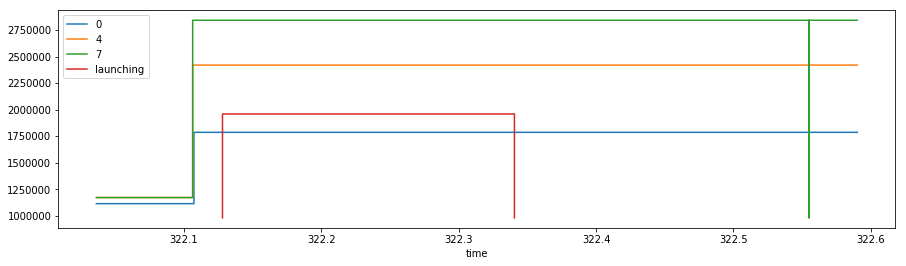

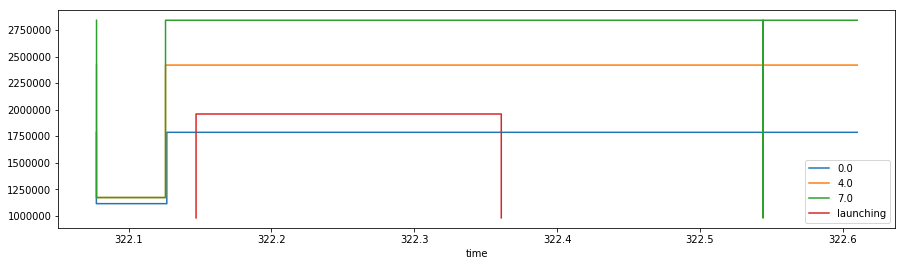

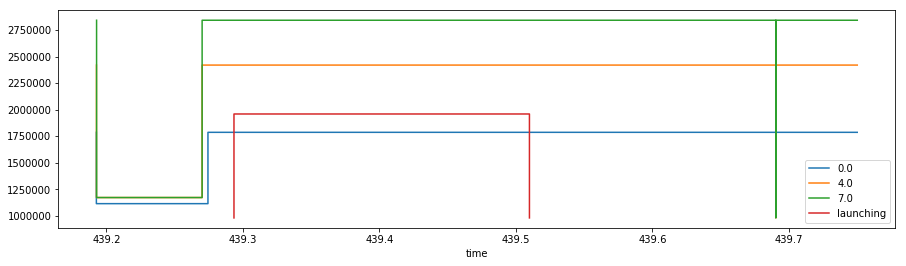

In [39]:
print(group1.title)
DrawCorrectedData(group1, CPU_FREQUENCY_LIMITS, 'min', 0)

GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222304_gallery


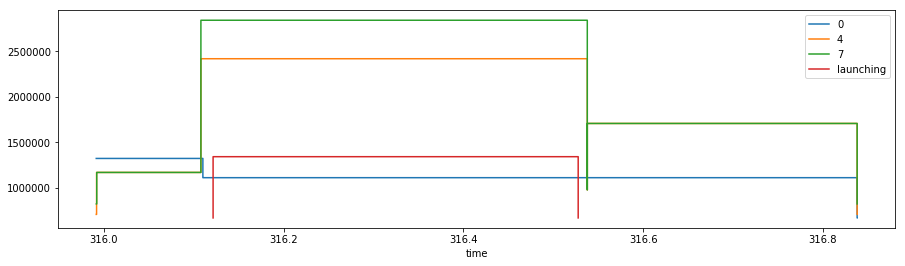

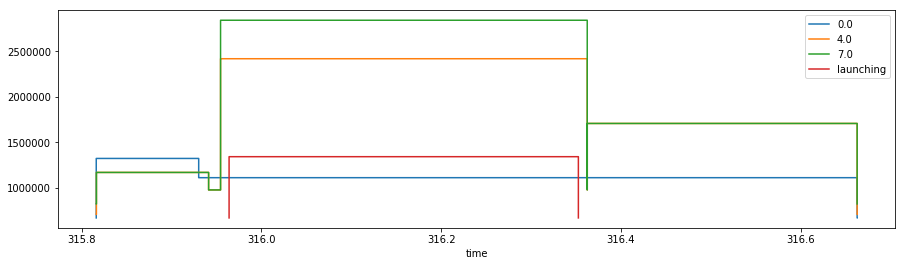

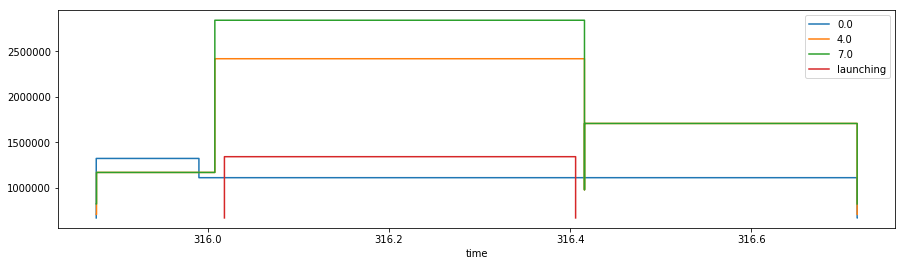

In [40]:
print(group2.title)
DrawCorrectedData(group2, CPU_FREQUENCY_LIMITS, 'min', 0)

### Cpu Idle

The graph to show a min lock status of core Idle.

In [39]:
from systrace_parser import CPU_IDLE
def PreprocessingForCPUIDLE(df):
    try :
        df_launching = df[df.cpu_id == 'launching']
    except :
        df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

        df.loc[df.state >= 4294967295, 'state'] = -1
        df['state'] = df['state'] + 1
        
        return df

    df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

    df.loc[df.state >= 4294967295, 'state'] = -1
    df['state'] = df['state'] + 1
    
    df = df[df.time >= (df_launching['time'].iloc[0] - 0.1)]
    df = df[df.time <= (df_launching['time'].iloc[1] + 0.1)]
    
    df = pd.concat([df, df_launching])
    return df

GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144926_gallery


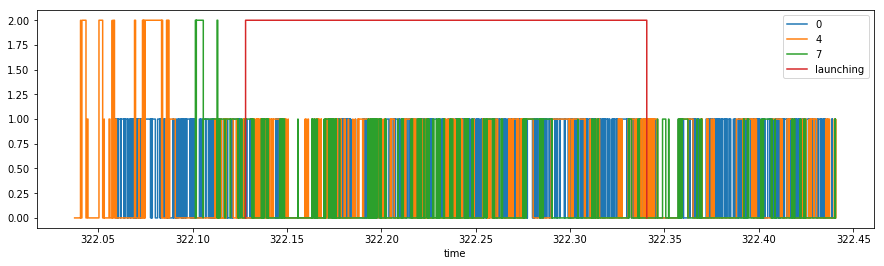

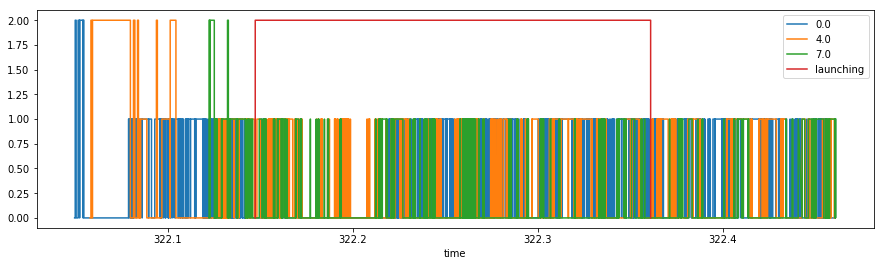

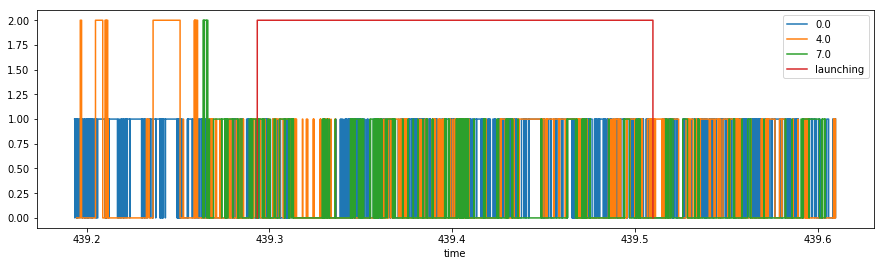

In [42]:
print(group1.title)
DrawCorrectedData(group1, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222304_gallery


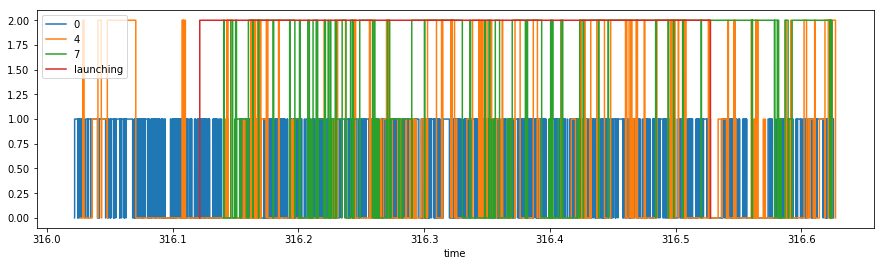

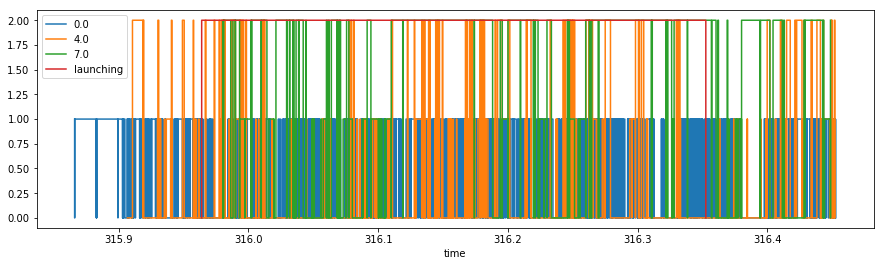

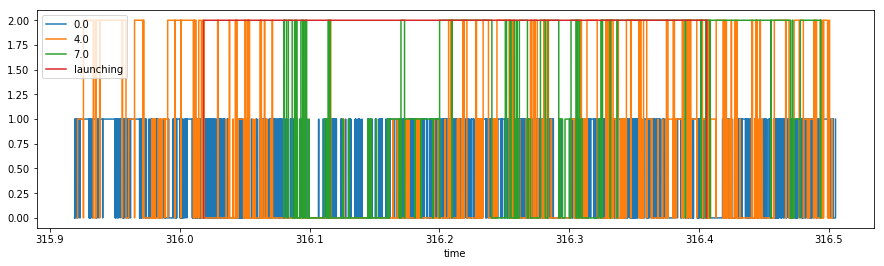

In [43]:
print(group2.title)
DrawCorrectedData(group2, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

### Lock Contention

In [42]:
df1 = group1.get(['lock_contention']) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(['lock_contention']) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

In [45]:
display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
#display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144926_gallery,lock_contention,0,6.868,0,7.572,17.242,10.496,4.848,0
GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222304_gallery,lock_contention,0,11.066,0,0.000,13.695,0.000,2.449,0
DIFF,lock_contention,0,-4.198,0,7.572,3.547,10.496,2.399,0


In [44]:
def DrawLockContention(parser):
    for lock_contention in parser.storage_lock_contention:
        lock_contention['owner'] = lock_contention['context'].split('owner ')[1].split(' waiters')[0]
        lock_contention['blocking'] = lock_contention['context'].split('blocking from')[1]
    df = DataFrame.from_dict(parser.storage_lock_contention)
    df.loc[df['duration'] > 0, 'duration'] *= 1000

    return df
        #if value == 'NaN':
            
        #else:
        #    display(DataFrame(df[value].value_counts()))

Liminated the lock contentions by the main thread is sleepping in an app.
(The effection means that lock contentions seem to effect to the app entry because the process stat was sleep.)

In [47]:
#for parser in group.parsers_of_testing:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df1 = df[df['effection'] == 'O']
display(group1.title)
display(df1.sort_values(by=['duration'], ascending=False))

u'GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144926_gallery'

,blocking,context,duration,effection,owner,pid,time,type
105,float com.android.server.wm.WindowManagerServ...,monitor contention with owner android.anim (15...,10.728,O,android.anim (1569),3085,322.174674,B
107,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (15...,10.498,O,android.anim (1569),1381,322.175002,B
40,int com.android.server.am.MultiWindowManagerS...,monitor contention with owner Binder:1243_12 (...,8.944,O,Binder:1243_12 (4986),1243,322.122614,B
94,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:1243_12 (...,4.160,O,Binder:1243_12 (4986),1381,322.160546,B
95,boolean com.android.server.wm.Session.getInTo...,monitor contention with owner Binder:1243_12 (...,4.152,O,Binder:1243_12 (4986),1569,322.160640,B
98,void com.android.server.am.TaskChangeNotifica...,monitor contention with owner Binder:1243_15 (...,3.779,O,Binder:1243_15 (7345),1366,322.165881,B
128,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:1243_16 (...,3.682,O,Binder:1243_16 (7404),1381,322.255679,B
109,void com.android.server.wm.StackWindowControl...,monitor contention with owner android.anim (15...,3.351,O,android.anim (1569),7345,322.182330,B
111,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (15...,3.334,O,android.anim (1569),7404,322.183070,B
104,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:1243_F (3...,3.296,O,Binder:1243_F (3085),1381,322.170162,B


In [48]:
#for parser in group.parsers_of_testing:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df2 = df[df['effection'] == 'O']
display(group2.title)
display(df2.sort_values(by=['duration'], ascending=False))

u'GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222304_gallery'

,blocking,context,duration,effection,owner,pid,time,type
102,void com.android.server.wm.WindowSurfacePlace...,monitor contention with owner Binder:1501_3 (1...,13.584,O,Binder:1501_3 (1905) at void com.android.serve...,1541,316.527962,B
5,android.app.ActivityManager$StackInfo com.and...,monitor contention with owner Binder:1501_7 (2...,13.192,O,Binder:1501_7 (2232) at void com.android.serve...,1537,316.133814,B
4,int com.android.server.wm.WindowManagerServic...,monitor contention with owner Binder:1501_7 (2...,8.671,O,Binder:1501_7 (2232) at void com.android.serve...,1541,316.133293,B
77,void android.content.res.AssetManager.applySt...,monitor contention with owner ThreadUtil (5819...,8.514,O,ThreadUtil (5819) at int android.content.res.A...,5776,316.230318,B
6,float com.android.server.wm.WindowManagerServ...,monitor contention with owner Binder:1501_7 (2...,6.364,O,Binder:1501_7 (2232) at void com.android.serve...,3489,316.141094,B
36,boolean com.android.server.wm.WindowProcessCo...,monitor contention with owner android.anim (15...,6.229,O,android.anim (1541) at void com.android.server...,1537,316.169542,B
78,void com.android.server.wm.TaskChangeNotifica...,monitor contention with owner Binder:1501_7 (2...,6.011,O,Binder:1501_7 (2232) at int com.android.server...,1537,316.241133,B
93,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (15...,4.950,O,android.anim (1541) at void com.android.server...,1537,316.292659,B
85,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:1501_9 (2...,4.569,O,Binder:1501_9 (2249) at int com.android.server...,1537,316.257244,B
7,int com.android.server.wm.WindowManagerServic...,monitor contention with owner android.anim (15...,4.503,O,android.anim (1541) at int com.android.server....,2232,316.143052,B


In [49]:
display(group1.title)
display(df1['duration'].sum())

u'GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144926_gallery'

86.59500000010212

In [50]:
display(group2.title)
display(df2['duration'].sum())

u'GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222304_gallery'

175.84600000003547

Sum of the lock contention's duration. The durations could be duplicated.

Liminated the lock contentions by owners.

In [51]:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group1.title)
display(DataFrame(df['owner'].value_counts()))

u'GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144926_gallery'

,owner
Binder:1243_12 (4986),14
android.anim (1569),13
Binder:1243_15 (7345),9
Binder:1243_16 (7404),9
android.ui (1367),6
Binder:1243_F (3085),4
Binder:1243_13 (5234),3
thumbThread1 (9905),2
thread-pool-2 (9916),2
Thread-52 (9885),2


In [52]:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group2.title)
display(DataFrame(df['owner'].value_counts()))

u'GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222304_gallery'

,owner
android.anim (1541) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:141),10
android.anim (1541) at void com.android.server.wm.InputMonitor$1.run()(InputMonitor.java:125),8
android.anim (1541) at void com.android.server.wm.WindowSurfacePlacer.lambda$new$0$WindowSurfacePlacer()(WindowSurfacePlacer.java:61),6
"Binder:1501_9 (2249) at void com.android.server.wm.WindowManagerService.removeWindow(com.android.server.wm.Session, android.view.IWindow)(WindowManagerService.java:1919)",6
"Binder:1501_7 (2232) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:2176)",4
"Binder:1501_3 (1905) at void com.android.server.am.ActivityManagerService.serviceDoneExecuting(android.os.IBinder, int, int, int)(ActivityManagerService.java:15655)",3
Binder:1501_9 (2249) at java.util.List com.android.server.am.ActivityManagerService.getRunningAppProcesses()(ActivityManagerService.java:11103),3
"Binder:1501_7 (2232) at int com.android.server.wm.WindowManagerService.addWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.view.InputChannel, android.view.InsetsState)(WindowManagerService.java:1345)",3
Binder:1501_7 (2232) at void com.android.server.wm.ActivityTaskManagerService.activityPaused(android.os.IBinder)(ActivityTaskManagerService.java:2252),3
"android.anim (1541) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:2176)",3


Text(0,0.5,'weight')

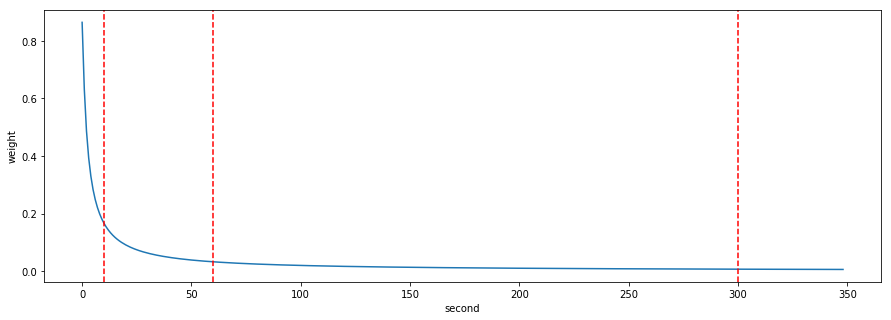

In [51]:
from math import exp


#display(np.exp(-2.0/np.arange(1,300.0)) * 2048)
plt.figure(figsize=(15,5))
plt.plot(1 - np.exp(-2.0/np.arange(1,350.0)))
plt.axvline(x=10, color='r', linestyle='--')
plt.axvline(x=60, color='r', linestyle='--')
plt.axvline(x=300, color='r', linestyle='--')
plt.xlabel('second')
plt.ylabel('weight')